# Python Operators
This example shows how to run custom Python code using a family of DALI `PythonFunction` Operators to **prototype new augmentations** or **debug the Pipeline**. The idea behind these Operators is to provide a capability to execute Python code operating on DALI tensors' data within the pipeline execution.

Reference: https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/custom_operations/python_operator.html


## Defining  an operation
The first kind of Operator we will try is `PythonFunction`. It wraps a regular Python function and runs it inside a DALI Pipeline. 

Let us define such a function as an example. We will name it `edit_images`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm

from nvidia.dali import ops, types
from nvidia.dali.pipeline import Pipeline

Our function takes two arrays as inputs and returns two outputs. `PythonFunction` uses NumPy arrays as data format for CPU and CuPy arrays for GPU. Note that we do a copy of both images because the input data *should not be modified*.

In [2]:
def edit_images(img1, img2):
    """ 
    Creates a circular mask and uses it to swap those 
    circular parts between the two images
    """
    assert img1.shape == img2.shape
    h, w, c = img1.shape
    y, x = np.ogrid[0:h, 0:w]  # Returns mesh-grid `ndarrays`
    mask = (x - w / 2)**2 + (y - h / 2) ** 2 > h * w / 9
    # swap centers
    res1 = np.copy(img1)
    res1[mask] = img2[mask]
    res2 = np.copy(img2)
    res2[mask] = img1[mask]
    return res1, res2

## Defining a pipeline
To see the Operator in action, we implement a simple data pipeline. We wrap the `edit_images` by passing it as a `function` parameter to `PythonFunction`. See that, in addition to the function, we pass the number of outputs as a parameter.

Having constructed `PythonFunction` as seen below, we can use it in the `define_graph` method like any other Operator!

In [4]:
image_dir = 'data/images'

class CommonPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super().__init__(batch_size, num_threads, device_id, 
                         exec_async=False, exec_pipelined=False, seed=99)
        self.input1 = ops.FileReader(file_root=image_dir, random_shuffle=True)
        self.input2 = ops.FileReader(file_root=image_dir, random_shuffle=True)
        self.decode = ops.ImageDecoder(device='cpu', output_type=types.RGB)
        self.resize = ops.Resize(resize_x=300, resize_y=300)
    
    # NO define_graph ???? maybe because it is abstract parent
    
    def load(self):
        # Since ops.FileReader returns a batch, can you not just call input1 twice?
        jpgs1, labels = self.input1() # first batch
        jpgs2, labels = self.input2() # second batch 
        img1, img2 = self.decode([jpgs1, jpgs2])
        return self.resize([img1, img2])

    
class PythonFuncPipeline(CommonPipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super().__init__(batch_size, num_threads, device_id, image_dir)
        self.edit_images = ops.PythonFunction(function=edit_images, 
                                              num_outputs=2)
        
    def define_graph(self):
        imgs1, imgs2 = self.load()
        res1, res2 = self.edit_images(imgs1, imgs2)
        return res1, res2    

## Running the pipeline and visualizing the results
Now we can just run the pipeline as usual to see the results.

Note that we need not *necessarily* have two Pipelines, `CommonPipeline` and `PythonFuncPipeline`. We could just make one `MyPipeline` with `load` and `edit_images`, but this perhaps this makes more sense, since `ops.PythonFunction` requires certain flags, and will mostly be used for debugging, so you wouldn't want it in normal pipeline I think.

In [5]:
batch_size = 4

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j)) # <---<< note the `.at(j)`

In [7]:
pipe = PythonFuncPipeline(batch_size, 4, 0, image_dir)
pipe.build()
imgs1, imgs2 = pipe.run()

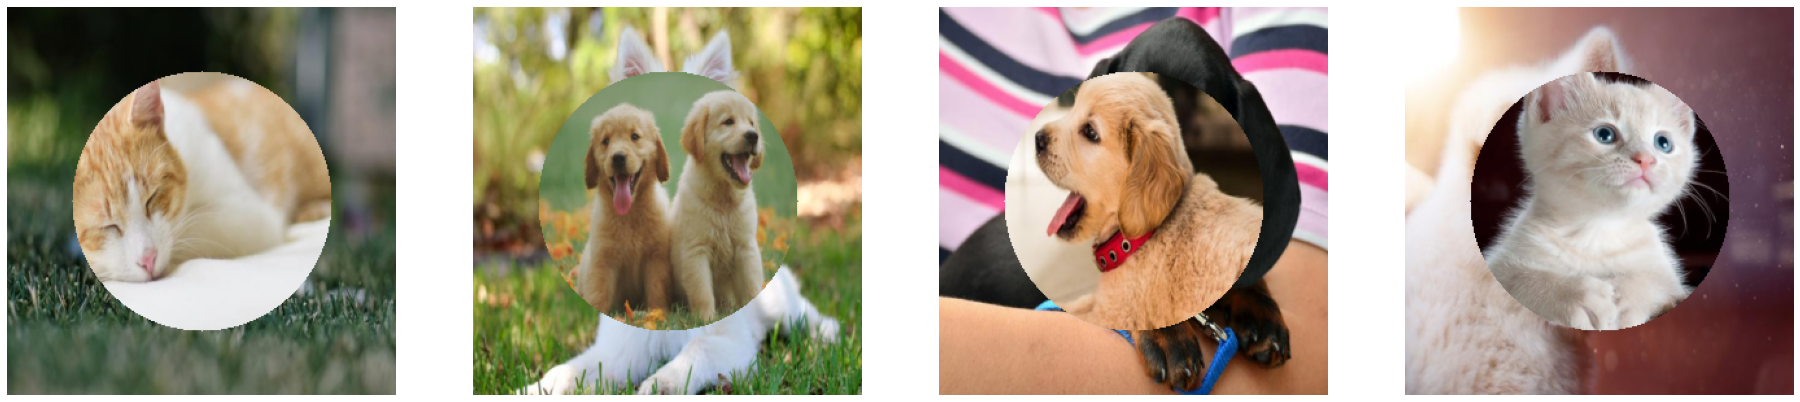

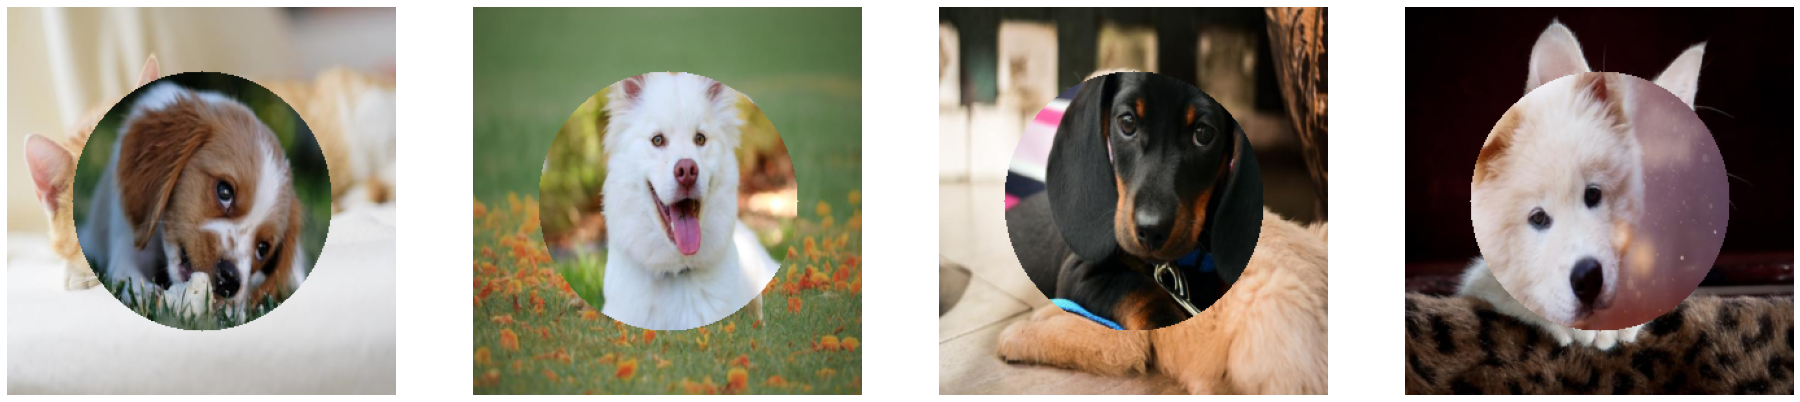

In [8]:
show_images(imgs1)
show_images(imgs2)

# Variety of Python Operators
`PythonFunction` comes in different flavors in DALI. The basic idea stays the same, but the data format on which the implementation operates differ:
- `PythonFunction`: works on arrays
- `TorchPythonFunction`: works on PyTorch tensors
- `DLTensorPythonFunction`: works on [DLPack](https://github.com/dmlc/dlpack) tensors

The most universal of these is `DLTensorPythonFunction` as DLPack is an open standard for tensor storage and many frameworks and libraries implement conversion methods from and to DLPack tensors. Internally, it is used to implement all the other kinds of Python Operator.

### `TorchPythonFunction` and `DLTensorPythonFunction`
The example below **presents the usage of PyTorch functions inside a DALI pipeline**. 

The preferred way to do this would be just utilizing the `TorchPythonFunction` Operator, but we will also use the `DLTensorPythonFunction` to show how to work with `DLPack` tensors.

We employ torchvision `RandomPerspective` transform in the `perspective` function, and we wrap it in `TorchPythonFunction`. 

The `dlpack_manipulation` function shows how to handle DLPack data. The input batch is converted to a list of PyTorch tensors, then it is processed and converted back to DLPack tensors.

Note that every Python operator has the `batch_processing` parameter. This param says whether the implementation function will get the *whole batch* as a list of tensors or it will be called per sample. Due to historical reasons, for `DLTensorPythonFunction`, this param is set to *True* by default. We can look at `dlpack_manipulation` to see how to deal with this kind of input.

In [9]:
import torch
import torch.utils.dlpack as torch_dlpack
from torchvision import transforms
import nvidia.dali.plugin.pytorch as dalitorch

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomPerspective(p=1.),
                                transforms.ToTensor()])

def perspective(t):
    return transform(t).transpose(2, 0).transpose(0, 1) # this is ugly

def dlpack_manipulation(dlpacks): # this is also ugly
    # dlpack --> f(tensor) --> dlpack
    tensors = [torch_dlpack.from_dlpack(dlp) for dlp in dlpacks]
    output = [(tensor.to(torch.float32) / 255.).sqrt() for tensor in tensors]
    output.reverse()
    return [torch_dlpack.to_dlpack(tensor) for tensor in output]

class TorchFuncPipeline(CommonPipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super().__init__(batch_size, num_threads, device_id, image_dir)
        self.norm = ops.CropMirrorNormalize(std=255., mean=0.)
        self.perspective = dalitorch.TorchPythonFunction(function=perspective)
        self.sqrt_color  = ops.DLTensorPythonFunction(function=dlpack_manipulation)
    
    def define_graph(self):
        images, _ = self.load()
        res1 = self.perspective(self.norm(images))
        res2 = self.sqrt_color(images)
        return res1, res2

In [10]:
torch_pipeline = TorchFuncPipeline(4, 4, 0, image_dir)
torch_pipeline.build()

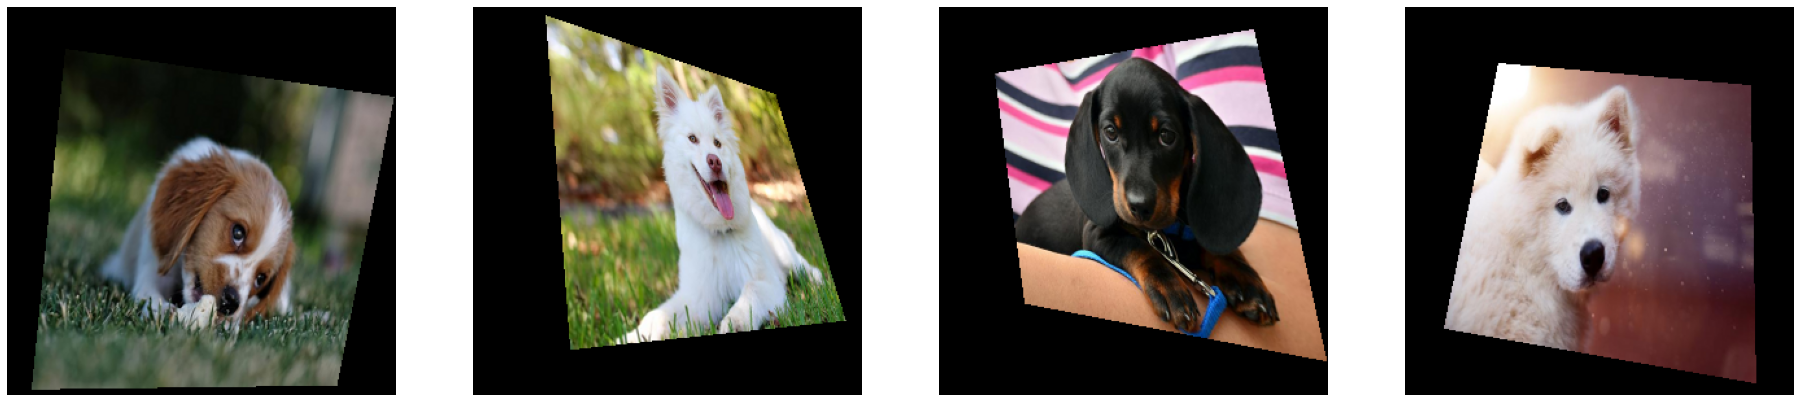

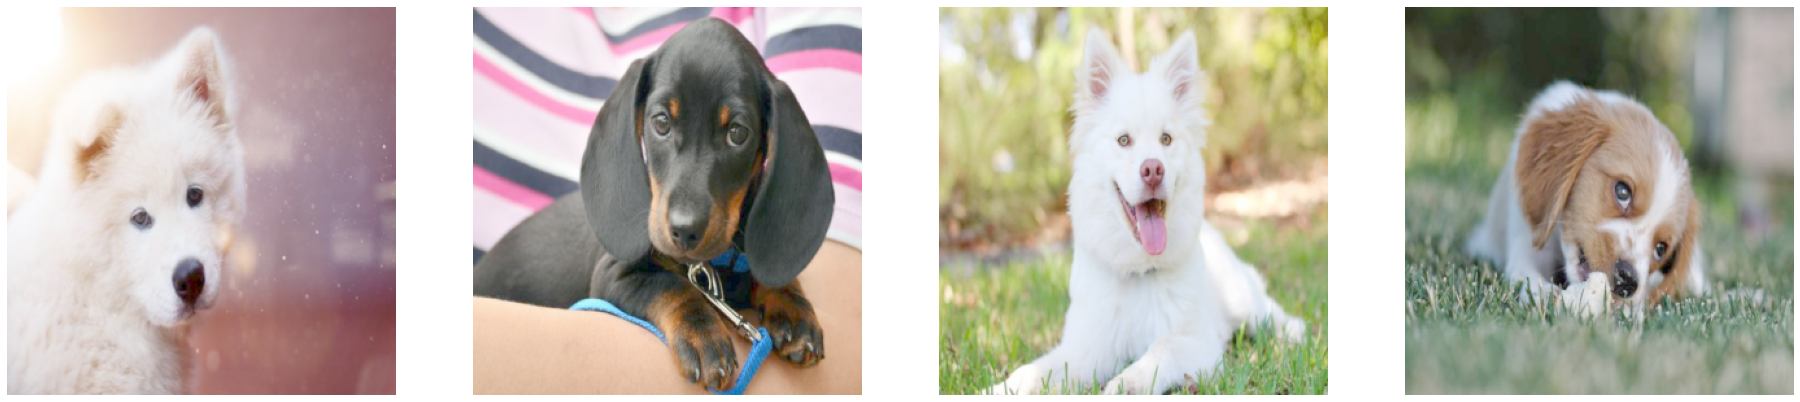

In [11]:
x, y = torch_pipeline.run()
show_images(x)
show_images(y)

# Limitations of Python operators
As we could see, pipelines that incorporate Python operators have to constructed with `exec_async=False` and `exec_pipelined=False` specified.

It was necessary to make it possible to call Python code from inside of DALI, but it degrades the performance of data pipelines. In addition, Python operators cannot utilize more than one CPU core due to the Python threading model.

Thus, Python operators **can be very useful for testing, debugging or prototyping**, but are not considered as a production level solution for extending DALI.